In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image


device = torch.device("cpu")
print(f"using device: {device}")

using device: cpu


In [2]:
image = Image.open('./data/im_test.png')
image = np.array(image.convert("RGB"))

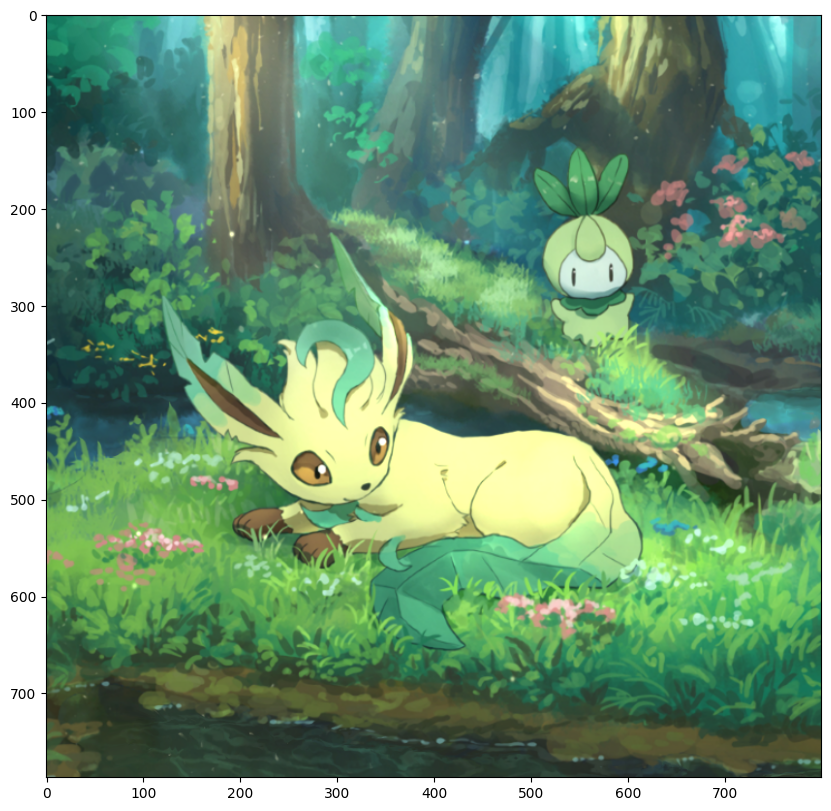

In [3]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [7]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "./model/sam2.1_hiera_small.pt"
model_cfg = "./model/sam2.1_hiera_s.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

MissingConfigException: Cannot find primary config './model/sam2.1_hiera_s.yaml'. Check that it's in your config search path.

Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=pkg://sam2
	provider=schema, path=structured://